# An Investigation of US Flights from 2008

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
    <ul>
        <li><a href="#generalprop">General Properties</a></li>
        <li><a href="#cleaning">Cleaning Steps</a></li>
    </ul>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

>This dataset reports flights in the United States, including
carriers, arrival and departure delays, and reasons for delays,
for 2008.
> Data links:
* Statistical Computing | Statistical Graphics: http://stat-computing.org/dataexpo/2009/the-data.html
* US Bureau of Transportation Statistics: https://www.transtats.bts.gov/Fields.asp?Table_ID=236

>The flight data may provide insight into what time of year to avoid traveling within the US based on delays and cancellations. We can also investigate where, or which airports, offer the best (or worst) flight experiences based on similar issues. Additionally, it may be interesting to understand why flights that are cancelled get cancelled and how long a delay take before becoming a cancellation.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

import bz2
import zipfile

<a id='wrangling'></a>
## Data Wrangling

>In this section of the report, we load in the data, check for cleanliness, and then trim and clean the dataset for analysis.

<a id='generalprop'></a>
### General Properties

In [3]:
df_full = pd.read_csv('./flightdata/2008.csv')
df_full.head()

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,...,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,2008,1,3,4,2003.0,1955,2211.0,2225,WN,335,...,4.0,8.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
1,2008,1,3,4,754.0,735,1002.0,1000,WN,3231,...,5.0,10.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
2,2008,1,3,4,628.0,620,804.0,750,WN,448,...,3.0,17.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
3,2008,1,3,4,926.0,930,1054.0,1100,WN,1746,...,3.0,7.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
4,2008,1,3,4,1829.0,1755,1959.0,1925,WN,3920,...,3.0,10.0,0,NaN,0,2.0,0.0,0.0,0.0,32.0


In [4]:
df_full.shape

(7009728, 29)

>### There are 7,009,728 flights in the datset. With 29 distinguishing features associated with each flight.

### Column descriptions:
![Column Descriptions](./data_column_info.png "Image of Column Descriptions from RITA")


In [5]:
# Before inital exploration and cleaning begins, make a copy of the original dataframe:
df = df_full.copy()

In [6]:
# Basic column info/ data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7009728 entries, 0 to 7009727
Data columns (total 29 columns):
Year                 int64
Month                int64
DayofMonth           int64
DayOfWeek            int64
DepTime              float64
CRSDepTime           int64
ArrTime              float64
CRSArrTime           int64
UniqueCarrier        object
FlightNum            int64
TailNum              object
ActualElapsedTime    float64
CRSElapsedTime       float64
AirTime              float64
ArrDelay             float64
DepDelay             float64
Origin               object
Dest                 object
Distance             int64
TaxiIn               float64
TaxiOut              float64
Cancelled            int64
CancellationCode     object
Diverted             int64
CarrierDelay         float64
WeatherDelay         float64
NASDelay             float64
SecurityDelay        float64
LateAircraftDelay    float64
dtypes: float64(14), int64(10), object(5)
memory usage: 1.5+ GB


In [7]:
# Examine first row of data for any weirdness
print(df.iloc[0])

Year                   2008
Month                     1
DayofMonth                3
DayOfWeek                 4
DepTime                2003
CRSDepTime             1955
ArrTime                2211
CRSArrTime             2225
UniqueCarrier            WN
FlightNum               335
TailNum              N712SW
ActualElapsedTime       128
CRSElapsedTime          150
AirTime                 116
ArrDelay                -14
DepDelay                  8
Origin                  IAD
Dest                    TPA
Distance                810
TaxiIn                    4
TaxiOut                   8
Cancelled                 0
CancellationCode        NaN
Diverted                  0
CarrierDelay            NaN
WeatherDelay            NaN
NASDelay                NaN
SecurityDelay           NaN
LateAircraftDelay       NaN
Name: 0, dtype: object


>### Some fields regarding time are cast as floats instead of ints to identify HHMM times and need to be updated. Some delay fields have nulls instead of zeros. 

In [8]:
# Number of Nulls per Column
df.isna().sum()

Year                       0
Month                      0
DayofMonth                 0
DayOfWeek                  0
DepTime               136246
CRSDepTime                 0
ArrTime               151649
CRSArrTime                 0
UniqueCarrier              0
FlightNum                  0
TailNum                83365
ActualElapsedTime     154699
CRSElapsedTime           844
AirTime               154699
ArrDelay              154699
DepDelay              136246
Origin                     0
Dest                       0
Distance                   0
TaxiIn                151649
TaxiOut               137058
Cancelled                  0
CancellationCode     6872294
Diverted                   0
CarrierDelay         5484993
WeatherDelay         5484993
NASDelay             5484993
SecurityDelay        5484993
LateAircraftDelay    5484993
dtype: int64

>### There are many fields with missing values; some will be replaced with zeros, but some (like DepTime and ArrTime) need to be investigated to understand if they are cancellations or errors.

In [9]:
# summary statistics of numeric columns
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Year,7009728.0,2008.000000,0.000000,2008.0,2008.0,2008.0,2008.0,2008.0
Month,7009728.0,6.375130,3.406737,1.0,3.0,6.0,9.0,12.0
DayofMonth,7009728.0,15.728015,8.797068,1.0,8.0,16.0,23.0,31.0
DayOfWeek,7009728.0,3.924182,1.988259,1.0,2.0,4.0,6.0,7.0
DepTime,6873482.0,1333.830046,478.068895,1.0,928.0,1325.0,1728.0,2400.0
CRSDepTime,7009728.0,1326.085663,464.250911,0.0,925.0,1320.0,1715.0,2359.0
ArrTime,6858079.0,1481.258227,505.225129,1.0,1107.0,1512.0,1909.0,2400.0
CRSArrTime,7009728.0,1494.801154,482.672822,0.0,1115.0,1517.0,1907.0,2400.0
FlightNum,7009728.0,2224.200105,1961.715999,1.0,622.0,1571.0,3518.0,9743.0
ActualElapsedTime,6855029.0,127.322424,70.187308,12.0,77.0,110.0,157.0,1379.0


>### There are some outliers in the data that need to be investigated: how can elapsed time be negative? how can elapsed time be as short as 12 minutes? what flight is only 11 miles long?

In [29]:
# Origin Airports
print(len(df.Origin.value_counts()))
df.Origin.value_counts()[0:10]

303


ATL    413531
ORD    349579
DFW    280646
DEN    240916
LAX    215132
PHX    198966
IAH    184664
LAS    172537
DTW    161587
SFO    140245
Name: Origin, dtype: int64

In [30]:
# Destination Airports
print(len(df.Dest.value_counts()))
df.Dest.value_counts()[0:10]

302


ATL    413449
ORD    349425
DFW    280151
DEN    241086
LAX    215448
PHX    199083
IAH    184391
LAS    172471
DTW    161794
SFO    140336
Name: Dest, dtype: int64

In [28]:
# Unique Carrier Counts
df.UniqueCarrier.value_counts()

WN    1199300
AA     602925
OO     565848
MQ     489492
US     452668
DL     450747
UA     448520
XE     373406
NW     347016
CO     297557
EV     279893
9E     261422
FL     260949
YV     254350
OH     197157
B6     195319
AS     150631
F9      95687
HA      61782
AQ       7794
Name: UniqueCarrier, dtype: int64

## Assessment for Cleaning Steps:
* DepTime, CRSDepTime, ArrTime, and CRSArrTime are floats/ints, but need to represent local, hhmm
* If no cancellation, CancellationCode should be E instead of NAN
* CarrierDelay, WeatherDelay, NASDelay, SecurityDelay, LateAircraftDelay should have 0 instead of NAN
* Need to understand how DepTime, ArrTime, and AirTime, ActualElapsedTime and CRSElapsedTime can be null - were those flights cancelled?

<a id='cleaning'></a>
## Data Cleaning Steps:

### Replace NaNs in CancellationCode with the letter 'E'

In [10]:
# Confirm that when a flight is NOT cancelled, the cancellation code is NaN
df[df.Cancelled==0].CancellationCode.unique()

array([nan], dtype=object)

In [11]:
df.CancellationCode.value_counts(dropna=False)

NaN    6872294
B        54904
A        54330
C        28188
D           12
Name: CancellationCode, dtype: int64

In [12]:
# Fill CancellationCode NaN's with 'E' to match the rest of the codes
values = {'CancellationCode': 'E'}
df.fillna(value=values, inplace=True)

In [13]:
# Check that all nulls are gone
df.CancellationCode.value_counts(dropna=False)

E    6872294
B      54904
A      54330
C      28188
D         12
Name: CancellationCode, dtype: int64

### Recast DepTime, CRSDepTime, ArrTime, and CRSArrTime as timestamps

In [14]:
time_col = ['DepTime', 'CRSDepTime', 'ArrTime', 'CRSArrTime']
# fill nulls with 9999 to distinguish from actual times
values = {'DepTime': 9999, 'CRSDepTime': 9999, 'ArrTime': 9999, 'CRSArrTime': 9999}
df.fillna(value=values, inplace=True)

In [15]:
# convert values to strings
df[time_col] = df[time_col].astype(int).astype(str)

In [16]:
# front-pad strings with 0's so all strings have 4 digits for hh mm
def padzero(s):
    timel = len(s)
    if timel < 4:
        add0 = 4 - timel
        return add0*'0'+s
    else:
        return s
    
for col in time_col:
    df[col] = df[col].apply(lambda x: padzero(x))

In [17]:
# convert to datetime with format '%H%M'.time()
for col in time_col:
    df[col] = pd.to_datetime(df[col], format='%H%M', errors='coerce').dt.time

In [18]:
# Check that all times are hours and minutes now
df[time_col]

,DepTime,CRSDepTime,ArrTime,CRSArrTime
0,20:03:00,19:55:00,22:11:00,22:25:00
1,07:54:00,07:35:00,10:02:00,10:00:00
2,06:28:00,06:20:00,08:04:00,07:50:00
3,09:26:00,09:30:00,10:54:00,11:00:00
4,18:29:00,17:55:00,19:59:00,19:25:00
5,19:40:00,19:15:00,21:21:00,21:10:00
6,19:37:00,18:30:00,20:37:00,19:40:00
7,10:39:00,10:40:00,11:32:00,11:50:00
8,06:17:00,06:15:00,06:52:00,06:50:00
9,16:20:00,16:20:00,16:39:00,16:55:00


### Remove rows where flight was not cancelled but there is no flight time
These flights will not have the information needed for analysis

In [19]:
# Identify nulls where flights were not cancelled
df[df.Cancelled==0].isna().sum()

Year                       0
Month                      0
DayofMonth                 0
DayOfWeek                  0
DepTime                  521
CRSDepTime                 0
ArrTime                16892
CRSArrTime               547
UniqueCarrier              0
FlightNum                  0
TailNum                    7
ActualElapsedTime      17265
CRSElapsedTime           598
AirTime                17265
ArrDelay               17265
DepDelay                   0
Origin                     0
Dest                       0
Distance                   0
TaxiIn                 14215
TaxiOut                    0
Cancelled                  0
CancellationCode           0
Diverted                   0
CarrierDelay         5347559
WeatherDelay         5347559
NASDelay             5347559
SecurityDelay        5347559
LateAircraftDelay    5347559
dtype: int64

In [20]:
df.shape

(7009728, 29)

In [21]:
# Indices where Cancelled = False and Elapsed Time is null
to_remove = df[(df.Cancelled==0) & (df.ActualElapsedTime.isnull())].index
len(to_remove), df.shape[0]-len(to_remove)

(17265, 6992463)

In [22]:
# Remove these indices from the dataframe
df.drop(index=to_remove, inplace=True)

# Check if the shape changed correctly
df.shape

(6992463, 29)

### Replace numeric nulls with 0

In [23]:
# identify numeric nulls again
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

num_col = df.select_dtypes(include=numerics).columns #head().transpose()
num_col

Index(['Year', 'Month', 'DayofMonth', 'DayOfWeek', 'FlightNum',
       'ActualElapsedTime', 'CRSElapsedTime', 'AirTime', 'ArrDelay',
       'DepDelay', 'Distance', 'TaxiIn', 'TaxiOut', 'Cancelled', 'Diverted',
       'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay',
       'LateAircraftDelay'],
      dtype='object')

In [24]:
# Check if nulls only occur when flights are cancelled
df[df.Cancelled==1].isna().sum()

Year                      0
Month                     0
DayofMonth                0
DayOfWeek                 0
DepTime              136246
CRSDepTime                0
ArrTime              137434
CRSArrTime                0
UniqueCarrier             0
FlightNum                 0
TailNum               83358
ActualElapsedTime    137434
CRSElapsedTime          246
AirTime              137434
ArrDelay             137434
DepDelay             136246
Origin                    0
Dest                      0
Distance                  0
TaxiIn               137434
TaxiOut              137058
Cancelled                 0
CancellationCode          0
Diverted                  0
CarrierDelay         137434
WeatherDelay         137434
NASDelay             137434
SecurityDelay        137434
LateAircraftDelay    137434
dtype: int64

In [25]:
# Identify nulls where flights were not cancelled
df[df.Cancelled==0].isna().sum()

Year                       0
Month                      0
DayofMonth                 0
DayOfWeek                  0
DepTime                  521
CRSDepTime                 0
ArrTime                 2668
CRSArrTime                 0
UniqueCarrier              0
FlightNum                  0
TailNum                    5
ActualElapsedTime          0
CRSElapsedTime             0
AirTime                    0
ArrDelay                   0
DepDelay                   0
Origin                     0
Dest                       0
Distance                   0
TaxiIn                     0
TaxiOut                    0
Cancelled                  0
CancellationCode           0
Diverted                   0
CarrierDelay         5330294
WeatherDelay         5330294
NASDelay             5330294
SecurityDelay        5330294
LateAircraftDelay    5330294
dtype: int64

In [26]:
# Delays and elapsed times and taxi times are replaced with zeros
values = {'CarrierDelay':0, 'WeatherDelay':0, 
          'NASDelay':0, 'SecurityDelay':0, 
          'LateAircraftDelay':0, 'AirTime': 0,
          'ArrDelay': 0, 'DepDelay': 0,
          'TaxiIn': 0, 'TaxiOut': 0,
          'ActualElapsedTime': 0, 'CRSElapsedTime': 0}
df.fillna(value=values, inplace=True)

# ArrTime and DepTime will be replaced with CRSArrTime and CRSDepTime respectively
values2 = {'ArrTime': df['CRSArrTime'], 'DepTime': df['CRSDepTime']}
df.fillna(value=values2, inplace=True)

In [27]:
# Check for nulls - all clean except TailNum, which is not necessary for this analysis
df.isna().sum()

Year                     0
Month                    0
DayofMonth               0
DayOfWeek                0
DepTime                  0
CRSDepTime               0
ArrTime                  0
CRSArrTime               0
UniqueCarrier            0
FlightNum                0
TailNum              83363
ActualElapsedTime        0
CRSElapsedTime           0
AirTime                  0
ArrDelay                 0
DepDelay                 0
Origin                   0
Dest                     0
Distance                 0
TaxiIn                   0
TaxiOut                  0
Cancelled                0
CancellationCode         0
Diverted                 0
CarrierDelay             0
WeatherDelay             0
NASDelay                 0
SecurityDelay            0
LateAircraftDelay        0
dtype: int64

### Eliminate extra Origin Airport

In [31]:
# One extra Origin airport
set(df.Origin.value_counts().index) - set(df.Dest.value_counts().index)

{'PUB'}

In [32]:
# Only two examples == neglibile for this analysis
df[df.Origin=='PUB']

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,...,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
3701794,2008,7,8,2,17:40:00,16:55:00,18:14:00,17:04:00,XE,104,...,5.0,18.0,0,E,0,0.0,45.0,25.0,0.0,0.0
3702095,2008,7,14,1,13:31:00,13:22:00,14:49:00,13:31:00,XE,117,...,8.0,41.0,0,E,0,0.0,9.0,69.0,0.0,0.0


In [33]:
# Remove unnecessary rows with PUB airport
df = df[df.Origin!='PUB']

<a id='eda'></a>
## Exploratory Data Analysis
### Over-arching Question: What are the causes of cancellations, and can we avoid getting on a cancelled flight?
<ul>
    <li><a href="#can">How many flights were cancelled in 2008?</a></li>
    <li><a href="#code">What is the most common reason for cancellation?</a></li>
    <li><a href="#dep">Where do cancellations occur?</a></li>
    <li><a href="#delay">Are all flights that are cancelled delayed first?</a><li>
    <ul>
        <li>If a flight is delayed before cancellation, how long is it delayed?</li>
        <li>If a flight is delayed for more than one reason, which reason cancels it</li>
    </ul>
    <li><a href="#taxi">Did cancelled flights spend much time on the runway?</a></li>
    <li><a href="#when">When do the most delays occur?</a></li>
    <ul>
        <li>Month? Day? Hour?</li>
    </ul>
    <li><a href="#orgdest">Do certain trips have more cancellations?</a></li>
    <li><a href="#dist">Are cancellations correlated with flight distance?</a></li>
    <li><a href="#carrier">Does a certain carrier have more cancellations?</a></li>
    </ul>

<a id="can"></a>
### Cancelled vs Not Cancelled Flights

In [34]:
cc = df['Cancelled'].value_counts()
cc[0]

6855027

In [185]:
cc

0    6855027
1     137434
Name: Cancelled, dtype: int64

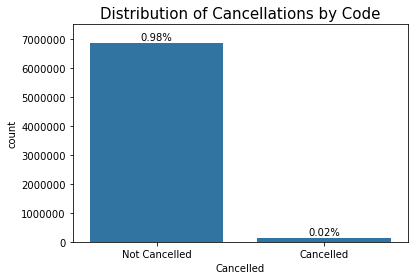

In [35]:
base_color = sb.color_palette()[0]
ax = sb.countplot(data = df, x = 'Cancelled', 
             color = base_color);
plt.ylim([0, 7500000])

# add annotations
n = df.shape[0]
cat_counts = df['Cancelled'].value_counts()
locs, labels = plt.xticks() # get the current tick locations and labels
cat_counts
# loop through each pair of locations and labels
for loc, label in zip(locs, labels):
    # get the text property for the label to get the correct count
    count = cat_counts[int(label.get_text())]
    ct_string = '{:0.2f}%'.format(count/n)
    plt.text(loc, count+100000, ct_string, ha = 'center', color = 'k')
    
plt.xticks([0, 1], ['Not Cancelled', 'Cancelled']);
plt.title('Distribution of Cancellations by Code', fontsize=15);

> **A large majority of flights were successful, while only a small number were cancelled. We'll mainly focus on just the cancelled flights (or relative number of cancelled flights by category) to see if we can determine where (by airline) most flights are cancelled, why (by cancellation code), and when (by month).**

#### Subsets of Cancelled or Not Cancelled Flights

In [124]:
# Create a subset of the data for cancelled flights:
df_cancelled = df.query('(Cancelled==1)')
df_notcancelled = df.query('(Cancelled==0)')
print('There were {:0.0f} cancelled flights out of {:0.0f} total flights in 2008'.format(df_cancelled.shape[0], df.shape[0]))

There were 137434 cancelled flights out of 6992461 total flights in 2008


<a id="code"></a>
### Distribution of Cancellation Codes

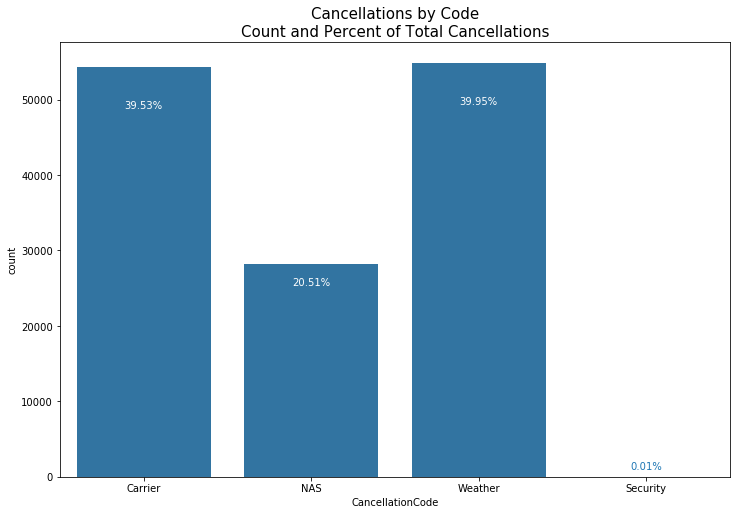

In [127]:
plt.figure(figsize=(12,8));
# Distribution of cancellation codes
cancel_codes = ['Carrier', 'NAS', 'Weather', 'Security']
locs = range(4)
base_color = sb.color_palette()[0]
ax = sb.countplot(data = df_cancelled, x = 'CancellationCode', 
             color = base_color);

# add annotations
n_points = df_cancelled.shape[0]
cat_counts = df_cancelled['CancellationCode'].value_counts()
locs, labels = plt.xticks() # get the current tick locations and labels

# loop through each pair of locations and labels
for loc, label in zip(locs, labels):
    # get the text property for the label to get the correct count
    count = cat_counts[label.get_text()]
    pct_string = '{:0.2f}%'.format(100*count/n_points)
    if count > 2000:
        # print the annotation just below the top of the bar
        plt.text(loc, 0.9*count, pct_string, ha = 'center', color = 'w')
    else:
        plt.text(loc, 1000, pct_string, ha = 'center', color = base_color)
    
plt.xticks(locs, cancel_codes);
plt.title('Cancellations by Code\nCount and Percent of Total Cancellations', fontsize=15);

> **Carrier and Weather are nearly tied for the most common causes of cancellations. Security makes up only 0.01% of all cancellations, while NAS falls somewhere in the middle at about 1/5 of all cancellations. It may be interesting to see if Carrier and Weather are also correlated with Origin Airports, such that airports in certain locations are more susceptible to poor weather and typically fly planes from certain carriers.**

<a id="dep"></a>
### Flights Cancelled by Origin Airport

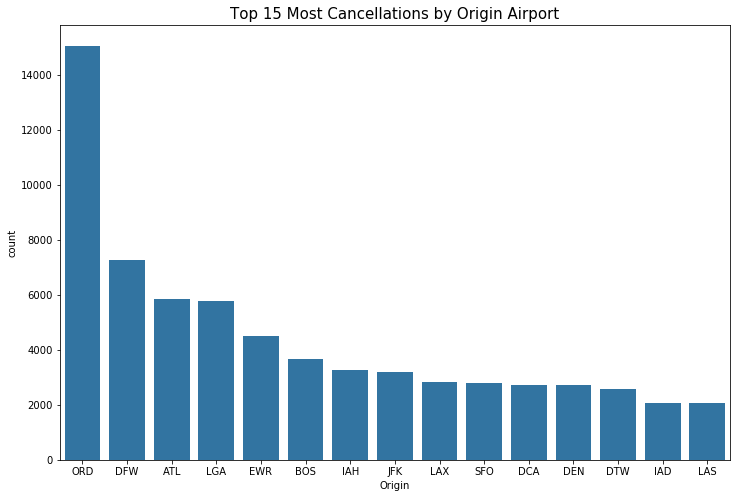

In [38]:
# Cancellations by Airports - most cancellations
base_color = sb.color_palette()[0]

top = (df_cancelled.Origin.value_counts()[0:15].index)
plt.figure(figsize=(12,8))
ax = sb.countplot(data = df_cancelled[df_cancelled.Origin.isin(top)], x='Origin', 
             color = base_color, order=top);
plt.title('Top 15 Most Cancellations by Origin Airport', fontsize=15);

In [190]:
df_cancelled.Origin.value_counts()[0:15] #.index)

ORD    15050
DFW     7272
ATL     5830
LGA     5753
EWR     4511
BOS     3655
IAH     3261
JFK     3196
LAX     2838
SFO     2790
DCA     2735
DEN     2725
DTW     2583
IAD     2077
LAS     2057
Name: Origin, dtype: int64

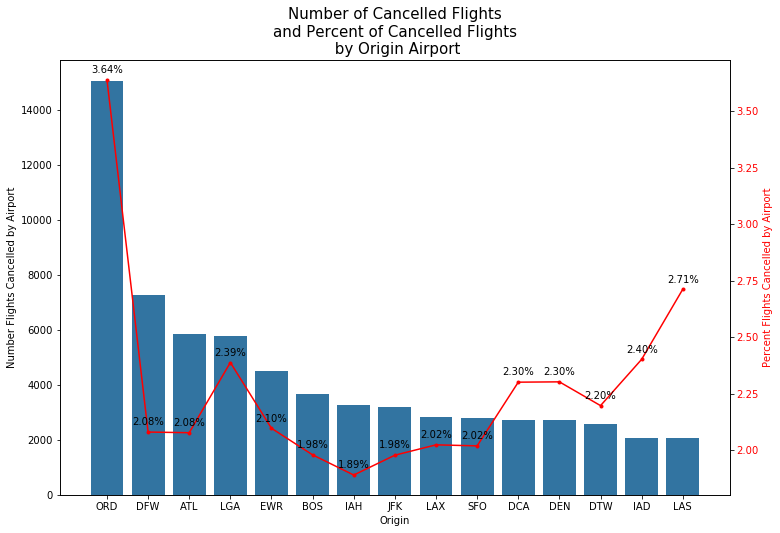

In [39]:
# % Cancelled Flights for the Top 15 Origina Airports with most cancellations
# ie. for each airport, the percentage of cancelled flights relative to that airport's total flights
# top = airport labels
top = (df_cancelled.Origin.value_counts()[0:15].index)
fig, ax1 = plt.subplots(figsize=(12,8))

ax1 = sb.countplot(data = df_cancelled[df_cancelled.Origin.isin(top)], x='Origin', 
             color = base_color, order=top);

n_points = df[df.Origin.isin(top)].Origin.value_counts().values
n_cancels = df_cancelled[df_cancelled.Origin.isin(top)].Origin.value_counts().values
locs = range(15)
locslabs = sorted(zip(locs, top, n_cancels, n_points), key=lambda x: x[1])

plt.title('Number of Cancelled Flights\nand Percent of Cancelled Flights\n by Origin Airport', fontsize=15);
ax1.set_ylabel('Number Flights Cancelled by Airport', color='k')  # we already handled the x-label with ax1

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
pct_cnl = 100* n_cancels/ n_points
# locs remains the same
ax2.plot(locs, pct_cnl, color='r', marker='.')
ax2.set_ylabel('Percent Flights Cancelled by Airport', color='r')  # we already handled the x-label with ax1
ax2.tick_params(axis='y', labelcolor='r')
for loc, label, can, tot in locslabs:
    pct_str = '{:0.2f}%'.format(100*can/tot)
    plt.text(loc, 100*can/tot+0.03, pct_str, ha='center', color='k')

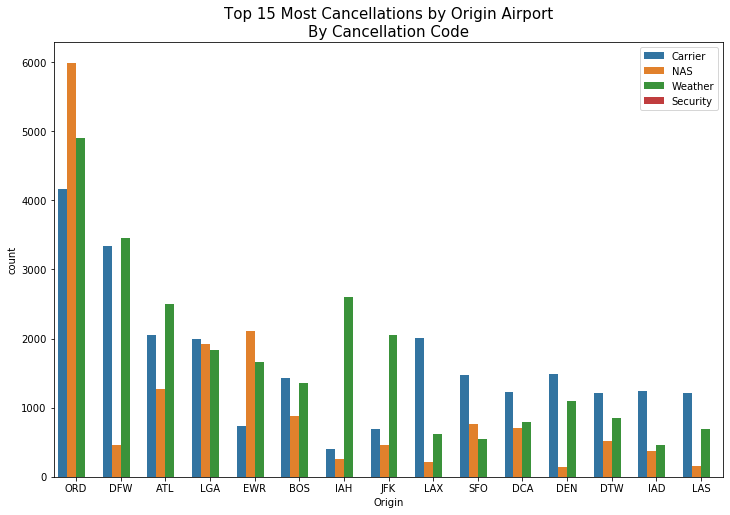

In [136]:
# Cancellations by Airports and codes - most cancellations
base_color = sb.color_palette()[0]

top = (df_cancelled.Origin.value_counts()[0:15].index)
plt.figure(figsize=(12,8))
ax = sb.countplot(data = df_cancelled[df_cancelled.Origin.isin(top)], x='Origin', 
             hue = 'CancellationCode', order=top);
plt.title('Top 15 Most Cancellations by Origin Airport\nBy Cancellation Code', fontsize=15);

plt.legend(['Carrier','NAS','Weather','Security']);

![alt text](cancelcodes.png "Cancellation Code Meanings")
>**Although NAS can refer to weather as well, we will keep NAS and Weather separate and will distinguish the two, knowing that Weather related to Extreme Weather, while NAS may be more common weather scenarios. Aside from Chicago (ORD) and Newark (EWR), most of the top volume airports experience cancellations due to Carrier and Weather issues. However, considering that Chicago and Newark often experience snow during the winter, many of their NAS cancellations may also be caused by weather.**

<a id="delay"></a>
### Cancelled Flights with Delays First

In [40]:
delay_types =  ['DepDelay', 'CarrierDelay','WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay']

In [41]:
# Flights that were not cancelled
df[df.Cancelled==0][delay_types].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
DepDelay,6855027.0,9.923840,35.203866,-534.0,-4.0,-1.0,8.0,2467.0
CarrierDelay,6855027.0,3.508114,20.016751,0.0,0.0,0.0,0.0,2436.0
WeatherDelay,6855027.0,0.675951,9.284361,0.0,0.0,0.0,0.0,1352.0
NASDelay,6855027.0,3.817842,16.650117,0.0,0.0,0.0,0.0,1357.0
SecurityDelay,6855027.0,0.016676,0.867370,0.0,0.0,0.0,0.0,392.0
LateAircraftDelay,6855027.0,4.620003,20.431509,0.0,0.0,0.0,0.0,1316.0


In [42]:
# Flights that were cancelled
df_cancelled[delay_types].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
DepDelay,137434.0,0.411201,9.034167,-20.0,0.0,0.0,0.0,712.0
CarrierDelay,137434.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
WeatherDelay,137434.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
NASDelay,137434.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
SecurityDelay,137434.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
LateAircraftDelay,137434.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0


> **Based on the descriptions, there are not many flights with delays that were not cancelled, but there were no flights with specified delays that were cancelled. Though there were some departure delays recorded prior to cancellation in the cancelled flights, because some have negative values (meaning they left early) those may be mistakes. Let's take a closer look at the departure delays for cancelled flights.**

In [43]:
# Number of delayed flights that were cancelled
num_delayed = df_cancelled[df_cancelled.DepDelay!=0].shape[0]
total_cancelled = df_cancelled.shape[0]
print("There were {0} delayed flights out of the total {1} flights that were cancelled".format(num_delayed, total_cancelled))

There were 1123 delayed flights out of the total 137434 flights that were cancelled


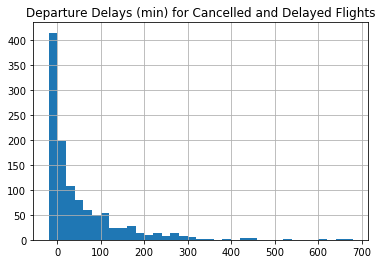

In [44]:
# Separate out the delayed+cancelled flights from the total cancelled flights
df_cancelled_delayed = df_cancelled.query('DepDelay!=0')
df_cancelled_delayed.DepDelay.hist(bins=np.arange(-20, 700, 20));
plt.title('Departure Delays (min) for Cancelled and Delayed Flights');

In [45]:
df_cancelled_delayed[df_cancelled_delayed.DepDelay<0].shape

# There were 415 cancelled flights with negative departure delays (seems like a mistake)

(415, 29)

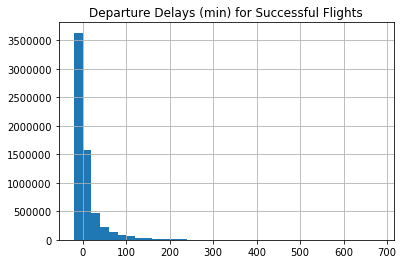

In [46]:
# Delayed flights that were not cancelled
df[(df.DepDelay!=0) & (df.Cancelled==0)].DepDelay.hist(bins=np.arange(-20,700,20));
plt.title('Departure Delays (min) for Successful Flights');

In [47]:
df[(df.DepDelay<0) & (df.Cancelled==0)].shape
# And 3,635,479 successful flights with negative departure delays (left early)

(3635479, 29)

>**It appears that, despite the difference in sample size, the cancelled flights that were delayed have a slightly higher percentage of longer delays (longer than 50 minutes). Otherwise, this comparison is not entirely conclusive; we may want to investigate TaxiOut time instead (ie. the time spent on the ground before take off or before cancelleation)**

<a id="taxi"></a>
### TaxiOut Time

In [48]:
df_cancelled.TaxiOut.describe().transpose()

count    137434.000000
mean          0.057635
std           1.446899
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         206.000000
Name: TaxiOut, dtype: float64

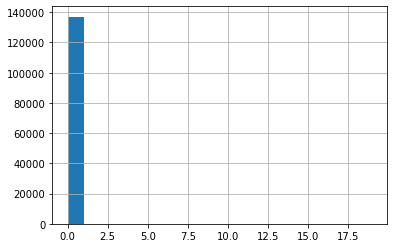

In [49]:
df_cancelled.TaxiOut.hist(bins=np.arange(0,20,1))

>**Similarly with TaxiOut time, there does not seem to be a significant amount of taxi time prior to cancellation.**

<a id="when"></a>
### When do Cancelled flights occur?
#### By Month

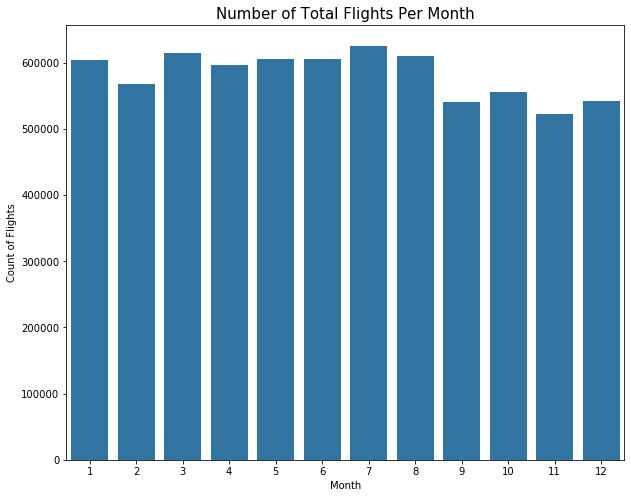

In [137]:
plt.figure(figsize=(10,8))
sb.countplot(data=df, x='Month', color=base_color);
plt.title("Number of Total Flights Per Month", fontsize=15);
plt.ylabel("Count of Flights");

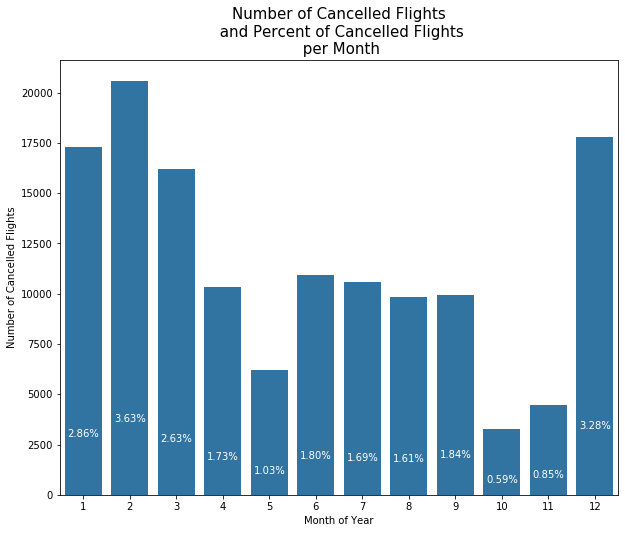

In [50]:
# Cancellations by month
plt.figure(figsize=(10,8))
sb.countplot(data=df_cancelled, x='Month', color=base_color);

tot_flights = df.Month.value_counts().sort_index().values
can_flights = df_cancelled.Month.value_counts().sort_index().values
locs = range(1,13)
locslabs = zip(locs, can_flights, tot_flights)

for loc, can, tot in locslabs:
    pct = 100*can/tot
    pct_str = '{:0.2f}%'.format(pct)
    plt.text(loc-1, pct*1000, pct_str, ha='center', color='w')
    
# plt.plot();
# plt.legend(['Percent Cancelled'], markerfirst=False, facecolor='w', scatterpoints=0);
plt.ylabel('Number of Cancelled Flights');
plt.xlabel('Month of Year');
plt.title('Number of Cancelled Flights\n and Percent of Cancelled Flights\n per Month', fontsize=15);

>**The most cancellations and the highest percentage of cancellations occur over the months of December, January, February, and March. This aligns with the findings above that most cancellations are related to weather or carrier. It would be interesting to see what types of cancellations occur during each month.**

In [51]:
df_cancelled.CancellationCode.value_counts()

B    54904
A    54330
C    28188
D       12
Name: CancellationCode, dtype: int64

C:\Users\v-cabad\AppData\Local\Continuum\anaconda3\envs\tf2\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


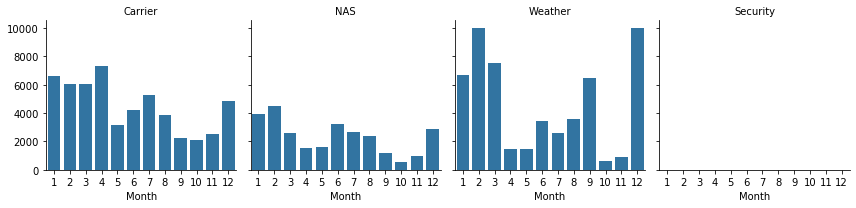

In [143]:
# Cancellation codes by month
df_cancelled['CancellationReason'] = df_cancelled['CancellationCode'].replace({'A': 'Carrier',
                                                              'B': 'Weather',
                                                               'C': 'NAS',
                                                                 'D': 'Security'})
                                                                 
g = sb.FacetGrid(df_cancelled, col="CancellationReason") 
g = g.map(sb.countplot, "Month", order=[1,2,3,4,5,6,7,8,9,10,11,12]).set_titles("{col_name}")

>**In the US, the most common delays over the winter/holiday months seems to be due to weather, followed by carrier, which is fairly consistent across all other months. NAS causes fewer cancellations, but also has slightly higher volumes during the winter months, which could also relate back to the weather sub-reason. Since there are only 12 examples of Security reasons causing cancellations those results are negligible.**

#### By Day of Week

In [53]:
df_cancelled.DayOfWeek.value_counts().sort_index()

1    20513
2    23168
3    20202
4    17884
5    23962
6    13567
7    18138
Name: DayOfWeek, dtype: int64

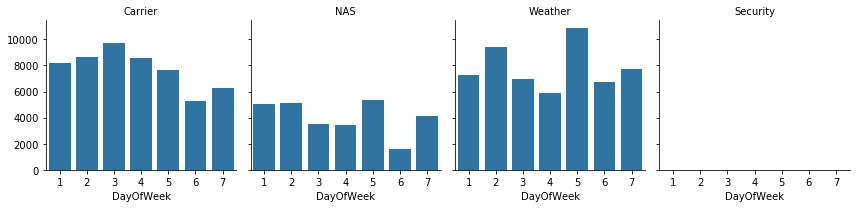

In [54]:
# Day of Week for Each Cancellation Code
g = sb.FacetGrid(df_cancelled, col="CancellationReason") 
g = g.map(sb.countplot, "DayOfWeek", order=[1,2,3,4,5,6,7]).set_titles("{col_name}")

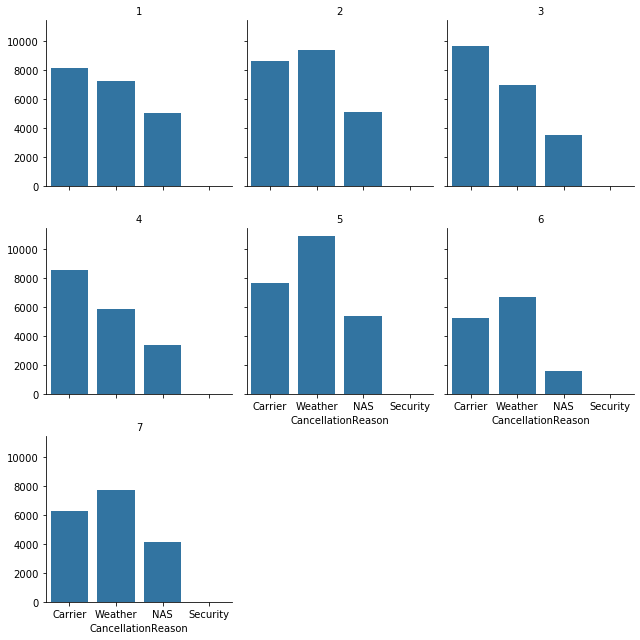

In [55]:
# Cancellation code for each Day of Week
g = sb.FacetGrid(df_cancelled, col="DayOfWeek", col_wrap=3) 
g = g.map(sb.countplot, "CancellationReason", order=['Carrier','Weather','NAS','Security']).set_titles("{col_name}")

In [56]:
df.DayOfWeek.value_counts().sort_index()

1    1033922
2    1029159
3    1037197
4    1029854
5    1032834
6     855230
7     974265
Name: DayOfWeek, dtype: int64

>**Overall, there is not much of a difference between week days in terms of cancellations or cancellation codes. Saturday and Sunday have fewer flights in general, which leads them to have fewer cancellations relative to week days.**

#### By Hour of Scheduled Departure

In [96]:
df['CRSDepTimeHour'] = df.CRSDepTime.apply(lambda x: x.hour)

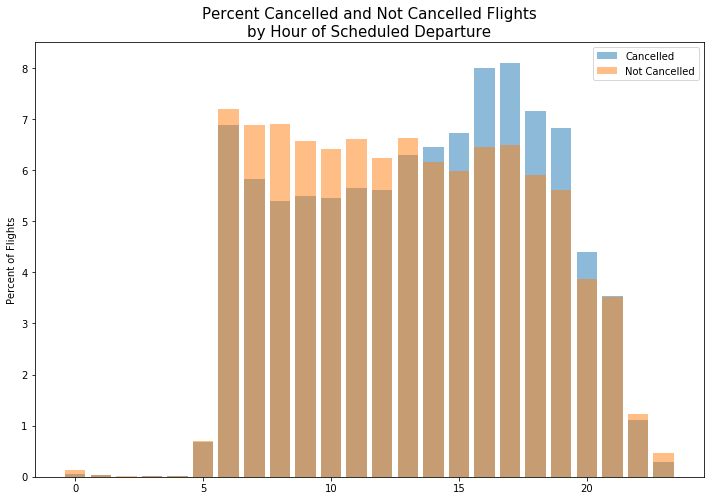

In [106]:
plt.figure(figsize=(12,8))

n_points_can = df[df.Cancelled==1].CRSDepTimeHour.value_counts().sort_index().values
n_cancels = df[df.Cancelled==1].shape[0]
pct_can = n_points_can / n_cancels*100

n_points = df[df.Cancelled==0].CRSDepTimeHour.value_counts().sort_index().values
n_nocan = df[df.Cancelled==0].shape[0]
pct_nocan = n_points / n_nocan*100
locs = range(24)

plt.bar(x=locs, height=pct_can, label='Cancelled', alpha=0.5);
plt.bar(x=locs, height=pct_nocan, label='Not Cancelled', alpha=0.5);
plt.legend();

plt.title('Percent Cancelled and Not Cancelled Flights\nby Hour of Scheduled Departure', fontsize=15);
plt.ylabel('Percent of Flights', color='k');  # we already handled the x-label with ax1


>**Most flights occur between 5am and 8pm, with a slightly higher percentage of cancellations occurring during the evening hours of 2pm to 8pm. This cannot truly be connected back to weather or carrier cancellations, but may have something to do with a decrease in visibility as the sun begins to go down after noon.**

<a id="orgdest"></a>
### Cancellations by Origin/Destination Combos

In [57]:
df['Org_Dest'] = df.Origin + '_' + df.Dest
df[['Org_Dest','Origin','Dest']]

,Org_Dest,Origin,Dest
0,IAD_TPA,IAD,TPA
1,IAD_TPA,IAD,TPA
2,IND_BWI,IND,BWI
3,IND_BWI,IND,BWI
4,IND_BWI,IND,BWI
5,IND_JAX,IND,JAX
6,IND_LAS,IND,LAS
7,IND_LAS,IND,LAS
8,IND_MCI,IND,MCI
9,IND_MCI,IND,MCI


In [58]:
df_cancelled['Org_Dest'] = df_cancelled.Origin + '_' + df_cancelled.Dest
df_cancelled[['Org_Dest','Origin','Dest']]

C:\Users\v-cabad\AppData\Local\Continuum\anaconda3\envs\tf2\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,Org_Dest,Origin,Dest
178,LAS_OAK,LAS,OAK
373,LAX_OAK,LAX,OAK
399,LAX_SFO,LAX,SFO
401,LAX_SFO,LAX,SFO
415,LAX_SJC,LAX,SJC
676,MDW_BDL,MDW,BDL
686,MDW_BNA,MDW,BNA
727,MDW_DTW,MDW,DTW
881,MDW_STL,MDW,STL
884,MDW_STL,MDW,STL


In [59]:
top = df_cancelled.Org_Dest.value_counts()[0:50]
top_org = list(set([c.split('_')[0] for c in top.index]))
top_dest = list(set([c.split('_')[1] for c in top.index]))
# print(top_org)
# print(top_dest)
top

LGA_ORD    852
ORD_LGA    826
BOS_LGA    822
LGA_BOS    817
DCA_LGA    768
LGA_DCA    752
HOU_DAL    507
SFO_LAX    489
LAX_SFO    455
DAL_HOU    440
LGA_ATL    435
DCA_ORD    416
ATL_LGA    410
ORD_MSP    396
ORD_DCA    392
MSP_ORD    388
EWR_ORD    387
BOS_PHL    381
ORD_CVG    380
ORD_EWR    377
CVG_ORD    374
DFW_ORD    365
PHL_BOS    363
ORD_DFW    363
MSN_ORD    362
ORD_MSN    353
BOS_ORD    346
ORD_BOS    336
BOS_JFK    334
ASE_DEN    332
JFK_BOS    329
PHL_ORD    328
LAS_PHX    320
DFW_LGA    319
DCA_BOS    316
DEN_ASE    311
ORD_PHL    309
LGA_DFW    307
ATL_ORD    291
MKE_ORD    283
ORD_ATL    280
ORD_STL    275
BOS_DCA    275
GRB_ORD    275
STL_ORD    272
DSM_ORD    269
DTW_ORD    269
CID_ORD    267
ORD_DSM    264
ORD_MKE    263
Name: Org_Dest, dtype: int64

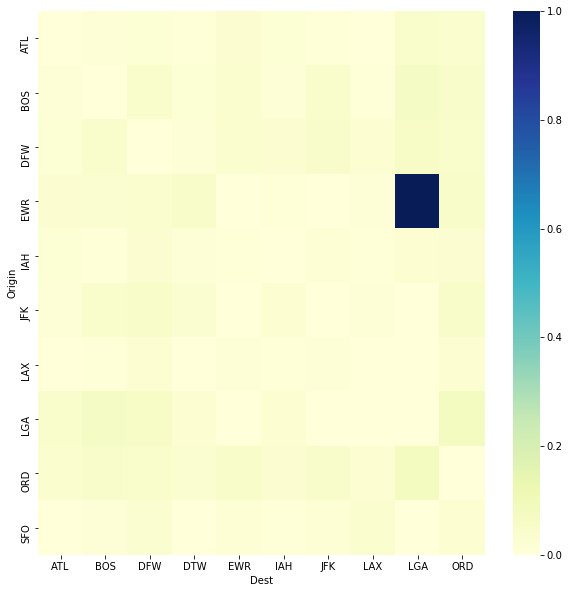

In [60]:
# Top 10 cancelled origins
# Top 10 cancelled destinations
# Percent cancellations for org/dest combos
df_orgdest = df[(df.Origin.isin(df_cancelled.Origin.value_counts()[0:10].index))&(df.Dest.isin(df_cancelled.Dest.value_counts()[0:10].index))][['Origin','Dest','Cancelled']]
orgdest = df_orgdest.pivot_table(index='Origin', columns='Dest', values='Cancelled', fill_value=0)
plt.figure(figsize=(10,10))
sb.heatmap(orgdest, cmap='YlGnBu');

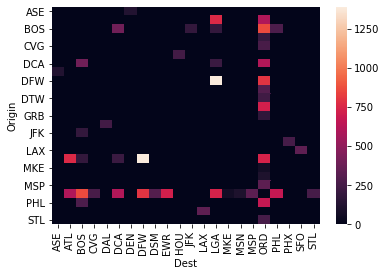

In [61]:
df_orgdest = df_cancelled[(df_cancelled.Org_Dest.isin(top.index))][['Origin','Dest','Distance']]
orgdest = df_orgdest.pivot_table(index='Origin', columns='Dest', values='Distance', fill_value=0)
sb.heatmap(orgdest);

#### Cancellations by Origin Airports and Trip Distance and Carrier

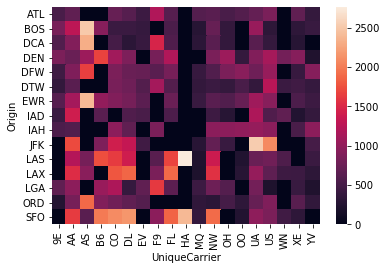

In [62]:
top_org = df_cancelled.Origin.value_counts()[0:15].index
df_sub = df_cancelled[df_cancelled.Origin.isin(top_org)].pivot_table(index='Origin',columns='UniqueCarrier',
                                                            values='Distance', fill_value=0)
sb.heatmap(df_sub);

>**Overall inconclusive - there are many origin destination pairs without cancellations and the data is so sparse it's difficult to come to any conclusions about which org-dest pairs experience the worst of cancellations. It is better for now, to continue analysis based on cancellations at a particular airport**

<a id="dist"></a>
### Cancellations by Distance

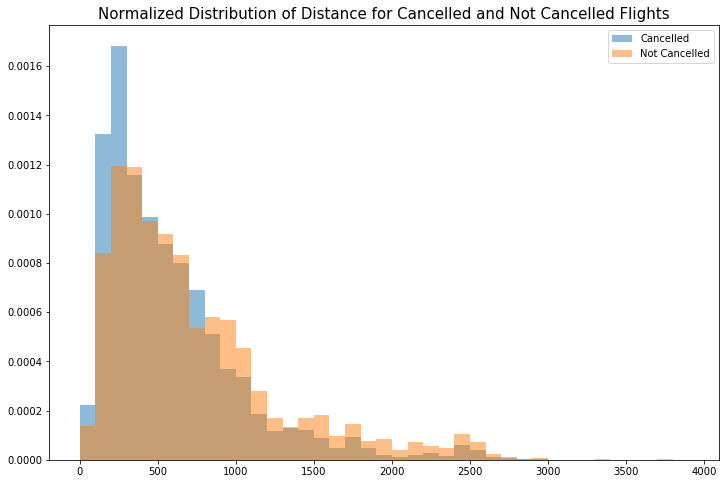

In [138]:
plt.figure(figsize=(12,8))
bins = np.arange(0, 4000, 100)
plt.hist(df[df.Cancelled==1]['Distance'], bins=bins,
         alpha=0.5, label='Cancelled', density=True);
plt.hist(df[df.Cancelled==0]['Distance'], bins=bins,
         alpha=0.5, label='Not Cancelled', density=True);
plt.legend();
plt.title("Normalized Distribution of Distance for Cancelled and Not Cancelled Flights", fontsize=15);

>**According to distributions alone, shorter flights seem to take up a higher percentage of cancelled flights than successful flights**

<a id="carrier"></a>
### Cancellations by Unique Carrier

In [111]:
len(df.UniqueCarrier.value_counts().index)

20

In [117]:
np.arange(0,20,1)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19])

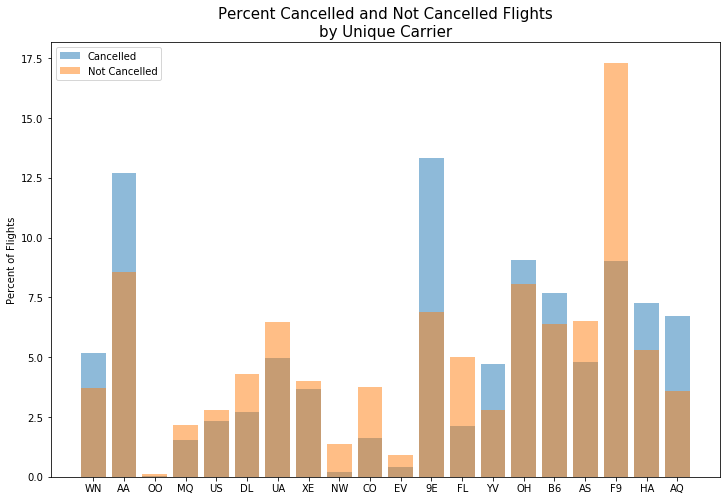

In [123]:
plt.figure(figsize=(12,8))

n_points_can = df[df.Cancelled==1].UniqueCarrier.value_counts().sort_index().values
n_cancels = df[df.Cancelled==1].shape[0]
pct_can = n_points_can / n_cancels*100

n_points = df[df.Cancelled==0].UniqueCarrier.value_counts().sort_index().values
n_nocan = df[df.Cancelled==0].shape[0]
pct_nocan = n_points / n_nocan*100
locs = np.arange(0,20,1)

plt.bar(x=locs, height=pct_can, label='Cancelled', alpha=0.5);
plt.bar(x=locs, height=pct_nocan, label='Not Cancelled', alpha=0.5);
plt.legend();
plt.xticks(locs, list(df.UniqueCarrier.value_counts().index));

plt.title('Percent Cancelled and Not Cancelled Flights\nby Unique Carrier', fontsize=15);
plt.ylabel('Percent of Flights', color='k');  # we already handled the x-label with ax1

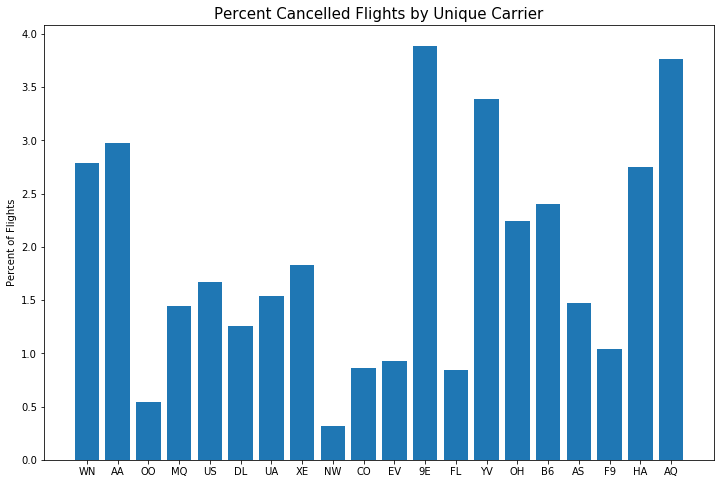

In [141]:
plt.figure(figsize=(12,8))

n_points_can = df[df.Cancelled==1].UniqueCarrier.value_counts().sort_index().values
n_points = df[df.Cancelled==0].UniqueCarrier.value_counts().sort_index().values
pct_can = n_points_can / n_points*100

locs = np.arange(0,20,1)

plt.bar(x=locs, height=pct_can, label='Cancelled');
plt.xticks(locs, list(df.UniqueCarrier.value_counts().index));

plt.title('Percent Cancelled Flights by Unique Carrier', fontsize=15);
plt.ylabel('Percent of Flights', color='k'); 

> **Some carriers have a higher percentage of cancellations than others: ``WN, AA, 9E, YV, OH, B6, HA, AQ``. These may be interesting to examine closer and see if they correlate with the cancellation code, time, distance, or departing airports which also exhibited more cancellations relatively.**

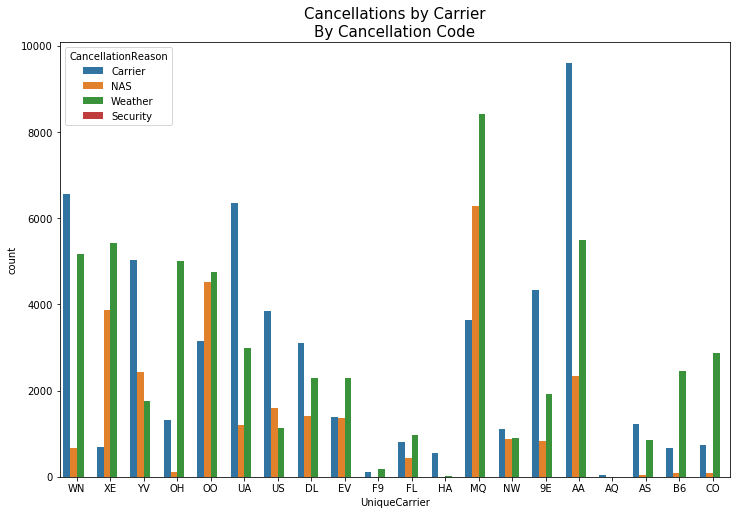

In [145]:
# Cancellations by Carriers and codes 
base_color = sb.color_palette()[0]

top = (df_cancelled.UniqueCarrier.value_counts().index)
plt.figure(figsize=(12,8))
ax = sb.countplot(data = df_cancelled, x='UniqueCarrier', 
             hue = 'CancellationReason');
plt.title('Cancellations by Carrier\nBy Cancellation Code', fontsize=15);

In [146]:
df.columns

Index(['Year', 'Month', 'DayofMonth', 'DayOfWeek', 'DepTime', 'CRSDepTime',
       'ArrTime', 'CRSArrTime', 'UniqueCarrier', 'FlightNum', 'TailNum',
       'ActualElapsedTime', 'CRSElapsedTime', 'AirTime', 'ArrDelay',
       'DepDelay', 'Origin', 'Dest', 'Distance', 'TaxiIn', 'TaxiOut',
       'Cancelled', 'CancellationCode', 'Diverted', 'CarrierDelay',
       'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay',
       'Org_Dest', 'CRSDepTimeHour'],
      dtype='object')

In [154]:
# top 15 origin airports and carriers used
df[df.Origin.isin(top_org)].groupby(['UniqueCarrier'])['Origin'].apply(set)

UniqueCarrier
9E    {DTW, LGA, ORD, DFW, EWR, BOS, ATL, DEN, IAD, ...
AA    {JFK, LGA, DTW, ORD, DFW, LAX, EWR, BOS, LAS, ...
AQ                                                {LAS}
AS        {ORD, DFW, LAX, EWR, BOS, LAS, DEN, DCA, SFO}
B6        {JFK, LGA, ORD, EWR, BOS, LAS, DEN, IAD, SFO}
CO    {DTW, LGA, JFK, ORD, EWR, LAX, DFW, BOS, LAS, ...
DL    {JFK, LGA, DTW, ORD, EWR, LAX, DFW, BOS, LAS, ...
EV    {DTW, LGA, JFK, ORD, DFW, EWR, BOS, ATL, IAD, ...
F9    {DTW, LGA, DFW, LAX, LAS, ATL, DEN, IAH, DCA, ...
FL    {DTW, LGA, DFW, EWR, LAX, BOS, LAS, ATL, DEN, ...
HA                                      {LAX, SFO, LAS}
MQ    {JFK, DTW, LGA, ORD, DFW, LAX, EWR, BOS, LAS, ...
NW    {DTW, LGA, JFK, ORD, EWR, LAX, DFW, BOS, LAS, ...
OH    {JFK, LGA, DTW, ORD, EWR, DFW, BOS, ATL, DEN, ...
OO    {DTW, ORD, EWR, DFW, LAX, LAS, ATL, DEN, IAH, ...
UA    {JFK, LGA, DTW, ORD, EWR, LAX, DFW, BOS, LAS, ...
US    {DTW, JFK, LGA, ORD, DFW, EWR, LAX, BOS, LAS, ...
WN                       {DTW, LAX

>**Not every carrier flies to every airport - this could help narrow down where the most cancellations occur by cross-referencing airport and carrier**

In [157]:
df_sub = df[df.Origin.isin(top_org)][['UniqueCarrier','Origin','Cancelled']]
df_sub

,UniqueCarrier,Origin,Cancelled
0,WN,IAD,0
1,WN,IAD,0
79,WN,LAS,0
80,WN,LAS,0
81,WN,LAS,0
82,WN,LAS,0
83,WN,LAS,0
84,WN,LAS,0
85,WN,LAS,0
86,WN,LAS,0


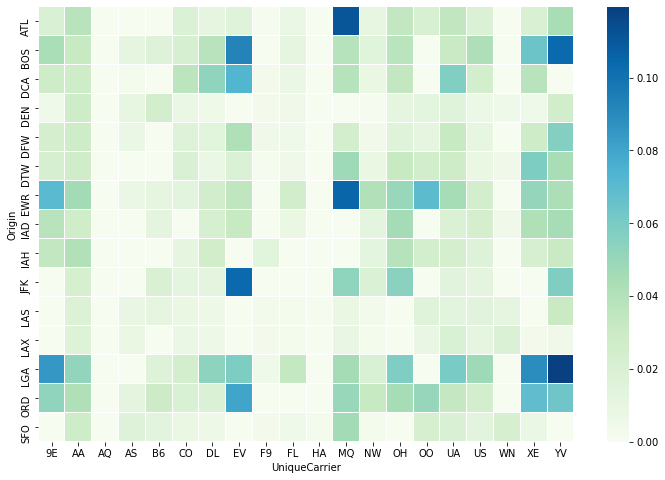

In [161]:
# Percent Cancellations by Origin and Carrier
plt.figure(figsize=(12,8))
df_subpiv = df_sub.pivot_table(index='Origin', columns='UniqueCarrier', 
                               values='Cancelled', fill_value=0)
sb.heatmap(df_subpiv, cmap='GnBu', linewidths=0.01);

>**There is definitely some overlap between origin and carrier, such that more cancellations occur with specific combinations: LGA has more cancellations with 9E, AA, DL, EV, XE, and YV, JFK with EV, EWR with MQ, ATL with MQ, BOS with YV, XE, and EV, and ORD with EV, XE, and YV.**

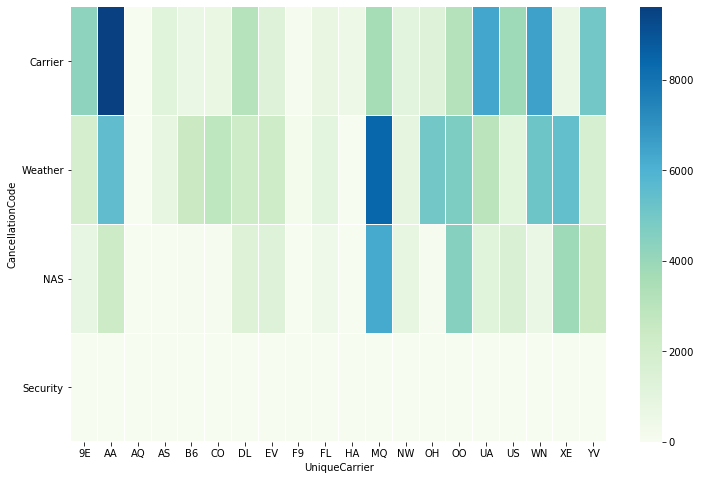

In [183]:
# Cancellations due to Carrier and Carriers - Summation
plt.figure(figsize=(12,8))
df_sub = df_cancelled[['UniqueCarrier','CancellationCode','Cancelled']]
df_subpiv = df_sub.pivot_table(index='CancellationCode', columns='UniqueCarrier', 
                               values='Cancelled', fill_value=0, aggfunc='sum')
ax = sb.heatmap(df_subpiv, cmap='GnBu', linewidths=0.01);
locs,labels = plt.yticks();
plt.yticks(locs, ['Carrier', 'Weather','NAS','Security'], rotation=0);

<a id='conclusions'></a>
## Conclusions
> After comparing cancellations to various flight aspects one by one, we can narrow down the leading factors of cancellation to a few factors, with some that overlap each other. The main contributing factors are month of the year, origin airport, carrier, and distance, with the leading causes being weather, carrier, and in part, NAS (National Aviation Service). Beginning with time of year, the most cancellations (and highest percentage of cancellations) occurred during the months of ``December, January, February, and March.`` Within those months, the majority of cancelled flights were cancelled due to weather; overall, most flights were cancelled due to weather, carrier, then NAS, with NAS also including a sub-reason related to weather. Weather cancellations during winter months seems to make sense, as snow storms in the US can be extreme enough to ground flights. Narrowing in on these higher volumes of cancelled flights, we begin to see that they are also tied to origin airports, carriers, and distance. These three other factors are also correlated with each other; each airport only supports certain carriers and certain destinations, while each carrier only goes to certain airports, which also limits the destinations to which carriers can travel. Altogether, the corresponding limits on origin-carrier-distance combinations lend themselves to an overall correlation to location and weather, which is one of the leading causes of cancellations, as well as carrier, which is another leading cause of cancellations. We can narrow down the most predictive features of cancelled flights by finding the combinations of month, origin airport, carrier, and distance (or technically also destination) where the highest percentages of cancellations fall.

> Luckily, cancellations made up a very small percentage of all flights during 2008 (only about 0.02% of almost 7 million total flights), and an even smaller number actually spent time on the tarmac, so in general, you had to be very unlucky to actually step onto a flight that wouldn't successfully take off. 

> Because this dataset only covers flights from one year, we cannot make any assumptions about predictions or yearly trends, but we can get a good idea of where to look in future broader analyses.


> **Tip**: Once you are satisfied with your work, you should save a copy of the report in HTML or PDF form via the **File** > **Download as** submenu. Before exporting your report, check over it to make sure that the flow of the report is complete. You should probably remove all of the "Tip" quotes like this one so that the presentation is as tidy as possible. Congratulations!

In [187]:
df.to_csv('cleaned_flights.csv')